In [9]:
# Gensim
import gensim
from gensim.models import Word2Vec

import os

import pandas as pd
import numpy as np

# custom
from analize_text import get_sentenceID
from paths import *

# nltk
import nltk
from nltk import word_tokenize
from nltk.stem.snowball import EnglishStemmer
from nltk import pos_tag, pos_tag_sents

from multiprocessing import cpu_count

# scikit learn
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder

# keras
from keras.utils import np_utils

Using TensorFlow backend.


In [10]:
# read dataframes of sentences and entities
sentences_df = pd.read_csv(SENTENCE_PATH)
entities_df = pd.read_csv(ENTITY_PATH)

In [139]:
print('Entities dataframe')
entities_df.head(20)

Entities dataframe


,entityID,name,position,type
0,DDI-DrugBank.d157.s0.e0,cimetidine,34-43,drug
1,DDI-DrugBank.d157.s0.e1,warfarin,49-56,drug
2,DDI-DrugBank.d157.s0.e2,Femara,97-102,brand
3,DDI-DrugBank.d157.s1.e0,Femara,48-53,brand
4,DDI-DrugBank.d157.s1.e1,tamoxifen,59-67,drug
5,DDI-DrugBank.d157.s1.e2,letrozole,108-116,drug
6,DDI-DrugBank.d157.s2.e0,Femara,54-59,brand
7,DDI-DrugBank.d110.s0.e0,anesthetic solutions,28-47,group
8,DDI-DrugBank.d110.s0.e1,epinephrine,60-70,drug
9,DDI-DrugBank.d110.s0.e2,norepinephrine,75-88,drug


In [49]:
print('Sentences dataframe')
sentences_df.head()

Sentences dataframe


,sentenceID,sentenceText
0,DDI-DrugBank.d157.s0,Clinical interaction studies with cimetidine a...
1,DDI-DrugBank.d157.s1,(See CLINICAL PHARMACOLOGY) Coadministration o...
2,DDI-DrugBank.d157.s2,There is no clinical experience to date on the...
3,DDI-DrugBank.d157.s3,Drug/Laboratory Test-Interactions None observed.
4,DDI-DrugBank.d110.s0,The administration of local anesthetic solutio...


### Load label dictionary {sentenceID: [ 'B', 'I', ..., 'O'] }

In [13]:
label_dict_path = os.path.join(ROOT_DIR, 'Train', 'bio_labels')
label_dict = np.load(label_dict_path + '.npy').item()

sentenceIDs = label_dict.keys()

In [14]:
# get sentences containing at least an entity 
sentences = [sentences_df[sentences_df.sentenceID == sentenceID]['sentenceText'].values[0] 
             for sentenceID in sentenceIDs]

# remove duplicates from sentence list (sentences with e.g. 2 entities appeared twice)
sentences = list(set(sentences))

In [13]:
### WTF ### happens iterating from sentences_df instead of indexing by entities 
dd = sentences_df['sentenceText']
for i, sentence in zip(range(len(dd)), dd.values):
    if not isinstance(sentence, str):
        print(i, True, sentence)
        break # remove this to see all

28 True nan


In [14]:
# just check nothing is wrong (it should not print anything)
for s in sentences:
    if not isinstance(s, str):
        print(True)

### Tokenize sentences

In [15]:
tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
tokenized_sentences[0]

['It',
 'was',
 'concluded',
 'that',
 ',',
 'although',
 'gentamycin',
 'did',
 'augment',
 'the',
 'neuromuscular',
 'blockade',
 'of',
 'atracurium',
 ',',
 'the',
 'effect',
 'was',
 'minimal',
 '.']

In [16]:
### EXAMPLE STEM + POS ####
# POS could differ slightly when applied to the stemmed version or not
# TODO: try which one performs better
stemmer = EnglishStemmer()
s = ['interaction', 'between', 'cimetidine', 'and', 'warfarin', 'could', 'be', 'dangerous']

print ('stemmed version:\n')
stemmed_s = [stemmer.stem(w) for w in s]
print (stemmed_s)

print ('\noriginal pos tags:\n')
print(pos_tag(s))

print ('\nstemmed pos tags:\n')
print(pos_tag(stemmed_s))

stemmed version:

['interact', 'between', 'cimetidin', 'and', 'warfarin', 'could', 'be', 'danger']

original pos tags:

[('interaction', 'NN'), ('between', 'IN'), ('cimetidine', 'NN'), ('and', 'CC'), ('warfarin', 'NN'), ('could', 'MD'), ('be', 'VB'), ('dangerous', 'JJ')]

stemmed pos tags:

[('interact', 'NN'), ('between', 'IN'), ('cimetidin', 'NN'), ('and', 'CC'), ('warfarin', 'NN'), ('could', 'MD'), ('be', 'VB'), ('danger', 'JJR')]


### POS tag

In [137]:
tokenized_sentences_pos = pos_tag_sents(tokenized_sentences, tagset=None) # tagset = None, 'universal', 'wsj', 'brown'

# concatenate the part of speach to each word (e.g. cat_NN)
tokenized_sentences_pos = [ [w + '_' + pos for w, pos in s ] for s in tokenized_sentences_pos]
tokenized_sentences_pos

[['It_PRP',
  'was_VBD',
  'concluded_VBN',
  'that_IN',
  ',_,',
  'although_IN',
  'gentamycin_NN',
  'did_VBD',
  'augment_VB',
  'the_DT',
  'neuromuscular_JJ',
  'blockade_NN',
  'of_IN',
  'atracurium_NN',
  ',_,',
  'the_DT',
  'effect_NN',
  'was_VBD',
  'minimal_JJ',
  '._.'],
 ['Inhibitory_JJ',
  'effects_NNS',
  'of_IN',
  'ruthenium_NN',
  'red_VBN',
  'on_IN',
  'inositol_NN',
  '1,4_CD',
  ',_,',
  '5-trisphosphate-induced_JJ',
  'responses_NNS',
  'in_IN',
  'rat_NN',
  'megakaryocytes_NNS',
  '._.'],
 ['Effect_NN',
  'of_IN',
  'dofetillide_NN',
  'on_IN',
  'the_DT',
  'pharmacokinetics_NNS',
  'of_IN',
  'digoxin_NN',
  '._.'],
 ['If_IN',
  'oral_JJ',
  'anticoagulants_NNS',
  'are_VBP',
  'also_RB',
  'being_VBG',
  'given_VBN',
  ',_,',
  'compensatory_NN',
  'increases_NNS',
  'in_IN',
  'clotting_VBG',
  'factor_NN',
  'synthesis_NN',
  'are_VBP',
  'impaired_VBN',
  '._.'],
 ['Intestinal_JJ',
  'adsorbents_NNS',
  '(_(',
  'e._JJ',
  'g._NN',
  ',_,',
  'charcoal

### Prepend label of BIO label of previous word
TODO

### Word2Vec

In [100]:
vector_size = 20
model = Word2Vec(tokenized_sentences_pos, size=vector_size, window=5, min_count=1, workers=cpu_count(), compute_loss=True)
model.train(sentences, total_examples=len(sentences), epochs=10)
print ('latest loss:', model.get_latest_training_loss())

latest loss: 0.0


In [101]:
# save embeddings and delete model
model.save("../word_vectors")
#model = Word2Vec.load('../word_vectors')
word_vectors = model.wv
del model

In [136]:
print(word_vectors["conduction_NN"])
print(word_vectors['Test-Interactions_NNP'])

[-0.0426175   0.21732736 -0.15975675 -0.6482836   0.00554066  0.29109132
  0.14246503 -0.36285526  0.44610095  0.24807703 -0.5835684  -0.5257857
  0.30919948 -0.68377197  0.3601129   0.17275675 -0.02416275  0.09001538
 -0.43085927  0.02361434]


KeyError: "word 'Test-Interactions_NNP' not in vocabulary"

#### create dataset

In [21]:
# create X_train, Y_train
X_train = np.array([]).reshape(0,vector_size)
Y_train = np.array([])

for sentenceID, labels in label_dict.items():
    sentence = sentences_df[sentences_df.sentenceID == sentenceID]['sentenceText'].values[0]
    tok_sentence = word_tokenize(sentence)
    tok_sentence_pos = [ word + '_' + pos for word, pos in pos_tag(tok_sentence, tagset=None)]

    for word, label in zip(tok_sentence_pos, labels):
        word_vector = word_vectors[word]
        X_train = np.vstack((X_train, word_vector))
        Y_train = np.append(Y_train, label)       

In [23]:
print (X_train.shape)
print (Y_train.shape)

(128806, 20)
(128806,)


### One-hot encoding of labels
Convert labels from B-I-O to $[1 0 0, 0 1 0, 0 0 1]$

In [24]:
# encode class values as integers = B-I-O -> 0-1-2
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y_train)
Y_train = encoded_Y # labels for the SVM
# convert integers to one-hot encoding
Y_train_one_hot = np_utils.to_categorical(encoded_Y) # labels for the ANN

## split train / validation set

In [25]:
# split train validation (SVM)
train_perc = 0.8
train_size = int(len(X_train) * train_perc)

X_tr, X_vl = X_train[:train_size,:], X_train[train_size:,:]
Y_tr, Y_vl = Y_train[:train_size], Y_train[train_size:]

print ('X shapes (TR/VL):', X_tr.shape, X_vl.shape)
print ('Y shapes (TR/VL):', Y_tr.shape, Y_vl.shape)

X shapes (TR/VL): (103044, 20) (25762, 20)
Y shapes (TR/VL): (103044,) (25762,)


In [27]:
# split train validatioin (NN)
Y_tr_nn, Y_vl_nn = Y_train_one_hot[:train_size], Y_train_one_hot[train_size:]

print ('Y shapes (TR/VL):', Y_tr_nn.shape, Y_vl_nn.shape)

Y shapes (TR/VL): (103044, 3) (25762, 3)


# Using SVM

In [35]:
from sklearn import svm

model = svm.SVC(kernel='rbf', C=1.0, class_weight=None, gamma='auto', tol=0.001, random_state=None)

In [36]:
model.fit(X_tr, Y_tr)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [40]:
print ('SVM validation accuracy:', round(model.score(X_vl, Y_vl),4))

('SVM validation accuracy:', 0.8648)


# Using ANN

In [42]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from sklearn import preprocessing
from keras.optimizers import *
from keras.initializers import *

import matplotlib.pyplot as plt

In [44]:
num_inputs = X_train.shape[1] # size of a vector
num_outputs = 3 # b-i-o tags

model_nn = Sequential()

model_nn.add(Dense(units=64, input_shape=(num_inputs,), activation='relu'))
model_nn.add(Dense(units=32, activation='relu'))
model_nn.add(Dense(units=num_outputs, activation='softmax'))

model_nn.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

model_nn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 3,523
Trainable params: 3,523
Non-trainable params: 0
_________________________________________________________________


In [46]:
epochs = 10
batch_size = 10

history = model_nn.fit(X_tr, Y_tr_nn, 
                    epochs=epochs, 
                    shuffle=True, 
                    verbose=1, 
                    batch_size=batch_size,
                    validation_data=(X_vl, Y_vl_nn))

Train on 103044 samples, validate on 25762 samples
Epoch 1/10
103044/103044 [==============================] - 10s 96us/step - loss: 0.2975 - acc: 0.8766 - val_loss: 0.2892 - val_acc: 0.8771
Epoch 2/10
103044/103044 [==============================] - 9s 91us/step - loss: 0.2780 - acc: 0.8830 - val_loss: 0.2751 - val_acc: 0.8853
Epoch 3/10
103044/103044 [==============================] - 9s 91us/step - loss: 0.2700 - acc: 0.8861 - val_loss: 0.2708 - val_acc: 0.8839
Epoch 4/10
103044/103044 [==============================] - 10s 93us/step - loss: 0.2626 - acc: 0.8886 - val_loss: 0.2633 - val_acc: 0.8863
Epoch 5/10
103044/103044 [==============================] - 10s 95us/step - loss: 0.2572 - acc: 0.8902 - val_loss: 0.2969 - val_acc: 0.8775
Epoch 6/10
103044/103044 [==============================] - 10s 98us/step - loss: 0.2527 - acc: 0.8919 - val_loss: 0.2559 - val_acc: 0.8904
Epoch 7/10
103044/103044 [==============================] - 10s 97us/step - loss: 0.2493 - acc: 0.8930 - val_lo

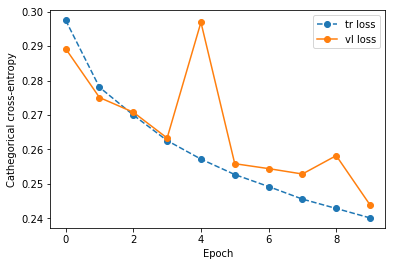

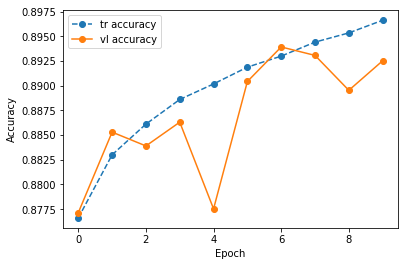

In [47]:
plt.plot(history.history['loss'], label='tr loss', linestyle='--', marker='o')
plt.plot(history.history['val_loss'], label='vl loss', linestyle='-', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Categorical cross-entropy')
plt.legend(loc='best')

plt.show()

plt.plot(history.history['acc'], label='tr accuracy', linestyle='--', marker='o')
plt.plot(history.history['val_acc'], label='vl accuracy', linestyle='-', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')

plt.show()

# Test
IdSentence|startOffset-endOffset|text|null

In [50]:
# read test .csv file containing (sentenceId, sentenceText)
test_sentences = pd.read_csv(SENTENCE_PATH)
test_sentences.head()

,sentenceID,sentenceText
0,DDI-DrugBank.d157.s0,Clinical interaction studies with cimetidine a...
1,DDI-DrugBank.d157.s1,(See CLINICAL PHARMACOLOGY) Coadministration o...
2,DDI-DrugBank.d157.s2,There is no clinical experience to date on the...
3,DDI-DrugBank.d157.s3,Drug/Laboratory Test-Interactions None observed.
4,DDI-DrugBank.d110.s0,The administration of local anesthetic solutio...


In [87]:
def token_spans(txt):
    token_offset = []
    tokens = nltk.word_tokenize(txt)
    offset = 0
    for token in tokens:
        offset = txt.find(token, offset)
        token_offset.append((token, offset, offset+len(token)-1))
        offset += len(token)
    return tokens, token_offset

In [120]:
def find_end_entity_index(labels_list, current_word_index):
    end_entity_index = current_word_index
    for i in range(current_word_index + 1, len(labels_list)):
        if labels_list[i] == 1: # if label == I
            end_entity_index += 1
            continue
        else:
            break
    return end_entity_index

In [135]:
for index, row in test_sentences.iterrows():
    sentenceId = row['sentenceID']
    sentenceText = row['sentenceText']
    # 1. tokenize sentence
    tok_sentence, token_offset = token_spans(sentenceText)
    # 2. add part of speech
    tok_sentence_pos = [ word + '_' + pos for word, pos in pos_tag(tok_sentence, tagset=None)]
    # 3. get word vectors, predict and write output line
    vectors_to_predict = np.array([]).reshape(0,vector_size)
    for word in tok_sentence_pos:
        vectors_to_predict = np.vstack((vectors_to_predict, word_vectors[word]))
    # 4. predict
    predictions = model_nn.predict(vectors_to_predict)
    predicted_labels = np.argmax(predictions, axis=1)
    # 5. generate output
    for i in range(len(predicted_labels)):
        if predicted_labels[i] == 0:
            end_entity_index = find_end_entity_index(predicted_labels, i)
            start = token_offset[i][1]
            end = token_offset[end_entity_index][2]
            print (sentenceID + '|' + str(start) + '-' + str(end) + '|' + sentenceText[start:end+1] + '|null')

DDI-DrugBank.d101.s1|34-43|cimetidine|null
DDI-DrugBank.d101.s1|49-56|warfarin|null


KeyError: "word 'Test-Interactions_NNP' not in vocabulary"

In [129]:
ll = [2, 0, 2, 0, 1, 2, 2, 2, 0, 1, 1, 2, 2]
for i in range(len(ll)):
    if ll[i] == 0:
        end_entity_index = find_end_entity_index(ll, i)
        print(i, end_entity_index)

1 1
3 4
8 10


In [40]:

        
sentence = "The cat eats fish, and the dog eats meat dog"

token_offset = spans(sentence)

#start = sentence.find("dog")
#start
token_offset

[('The', 0, 2),
 ('cat', 4, 6),
 ('eats', 8, 11),
 ('fish', 13, 16),
 (',', 17, 17),
 ('and', 19, 21),
 ('the', 23, 25),
 ('dog', 27, 29),
 ('eats', 31, 34),
 ('meat', 36, 39),
 ('dog', 41, 43)]

In [33]:
help(str.find)

Help on method_descriptor:

find(...)
    S.find(sub[, start[, end]]) -> int
    
    Return the lowest index in S where substring sub is found,
    such that sub is contained within S[start:end].  Optional
    arguments start and end are interpreted as in slice notation.
    
    Return -1 on failure.

